## AB Tests

### 1. Оценка результатов AB теста

Нужно оценить результаты AB теста. Даны результаты на контрольной и тестовой группе после проведения AB теста.
Помимо показателей целевой переменной, даны также несколько фичей, которые являются характеристиками объектов. Даны целевые показатели (y) и принадлежность к целевой группе (W).

Найдем treatment effect воздействия используя разные методы.

Для данной задачи используется dataset:  dataset_part1_students.csv

### 2. Оценка результатов AB теста с показателями до начала эксперимента

Необходимо как и ранее оценить результаты AB теста, а именно ATE. Теперь мы располагаем результатами до и после проведения теста (y_0 и y_1), а также дан treatment assignment (W). 


Как и в прошлом задании, попробуем оценить ATE используя разные методы и сравним результаты.

dataset_part2_students.csv

### 3. Построение uplift модели по результатам AB теста.

Даны результаты AB теста для модели конверсии клиента в продукте (conversion). Конверсия может принимать значения 1 или 0, что значит - клиент подключил услугу, либо не подключил соответственно.


Оценим ATE по данным, а также CATE для каждого наблюдения.

dataset_part3_students.csv

# Часть 1 

In [1]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.weightstats import CompareMeans
from statsmodels.stats.weightstats import DescrStatsW
import seaborn as sb
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportion_confint
from econml.dml import LinearDML
from sklearn.preprocessing import LabelEncoder

/home/dimsap/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
sb.set_style('darkgrid')

Скачаем данные и разобьем на treatment и control группы

In [3]:
data_part_1 = pd.read_csv('data/data/dataset_part1_students.csv', sep = '\t')
control_part1 = data_part_1[data_part_1.W == 0.0]
treatment_part1 = data_part_1[data_part_1.W == 1.0]

Посмотрим на данные

In [4]:
data_part_1.head()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
0,-1.459404,0.0,0.986277,0.873392,0.509746,0.271836,0.336919,0.216954,0.276477,0.343316,0.862159,0.156700
1,-1.694174,0.0,0.140887,0.757080,0.736325,0.355663,0.341093,0.666803,0.217101,0.561427,0.124179,0.319736
2,5.378374,0.0,0.953214,0.137357,0.569413,0.975665,0.503367,0.667664,0.034191,0.456119,0.155851,0.476049
3,2.188189,1.0,0.169702,0.896258,0.373394,0.379693,0.858317,0.646061,0.583462,0.668350,0.177793,0.849248
4,2.862696,1.0,0.442373,0.831468,0.763921,0.919691,0.070573,0.156165,0.636894,0.555696,0.191929,0.425656


In [5]:
data_part_1.describe()

,y,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,2.075323,0.522300,0.501970,0.496674,0.501623,0.501036,0.497661,0.501234,0.497832,0.496958,0.499980,0.498894
std,3.035037,0.499515,0.288250,0.289476,0.289892,0.288132,0.288567,0.288967,0.287840,0.288291,0.288345,0.287987
min,-9.047982,0.000000,0.000159,0.000013,0.000057,0.000028,0.000004,0.000073,0.000110,0.000057,0.000012,0.000013
25%,0.026237,0.000000,0.251363,0.244871,0.251427,0.250494,0.250537,0.250726,0.249500,0.247673,0.251035,0.250138
50%,2.075935,1.000000,0.503203,0.496624,0.504957,0.498941,0.498581,0.499502,0.499507,0.492757,0.499955,0.500853
75%,4.140186,1.000000,0.751609,0.745780,0.753342,0.752575,0.746653,0.752015,0.744436,0.746960,0.748775,0.745164
max,13.895502,1.000000,0.999966,0.999936,0.999960,0.999987,0.999948,0.999885,0.999970,0.999913,0.999906,0.999982


## 1) Проверка равенства средних в выборках
Для начала посмтрим на точечную оценку

In [6]:
print('mean_diff =', treatment_part1.y.mean() - control_part1.y.mean())

mean_diff = 0.4001031055444413


Видим, что отклонение не равно 0

Будем использовать t-test для проверки гипотезы о равенстве средних.  
Тогда, для корректных результатов такого теста, выборки должны быть из нормального распределения. Проверим это.

Посмотрим на распределения целевой переменной в двух группах 

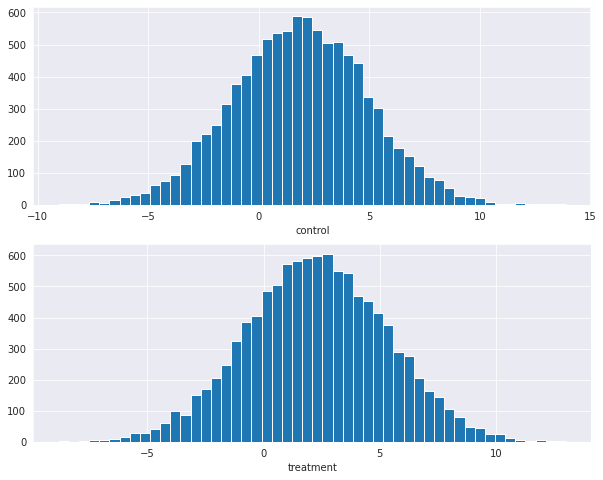

In [7]:
fig, ax = plt.subplots(2,1, figsize = (10,8))

ax[0].set_xlabel('control')
ax[1].set_xlabel('treatment')

control_part1.y.hist(bins = 50, ax = ax[0])
treatment_part1.y.hist(bins = 50, ax = ax[1])

Видим, что распределения похожи на нормальный.  
Построим Q-Q Plot чтобы убедиться в этом:

((array([-3.79931654, -3.57353433, -3.44954917, ...,  3.44954917,
          3.57353433,  3.79931654]),
  array([-9.04798172, -8.59837335, -8.3473165 , ..., 12.80560407,
         13.33207736, 13.89550194])),
 (3.0285060387368943, 1.866348968309554, 0.9999337362005631))

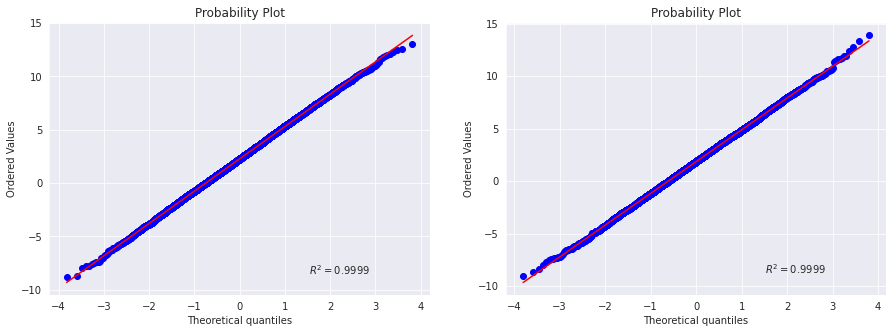

In [8]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
stats.probplot(treatment_part1.y, plot = ax[0], rvalue=True)
stats.probplot(control_part1.y, plot = ax[1], rvalue=True)


Видим, что точки очень хорошо ложаться на прямую, а $R^2$ почти равен 1 . Такой проверки должно быть достаточно для проведения t-теста так как он не чувствителен к небольшим отклонениям от нормальности. Однако для, для большей уверенности, проверим на нормальность распределения целевой переменной с помощью теста Шапиро-Уилка.  

H0 - целевая переменная распределена нормально  
H1 - распределение отличается от нормального  
Примем уровень значимости $\alpha =$0.05

In [9]:
print('для control p_value = ', stats.shapiro(control_part1.y[:5000]).pvalue)
print('для treatment p_value = ', stats.shapiro(treatment_part1.y[:5000]).pvalue)

для control p_value =  0.7025354504585266
для treatment p_value =  0.4698139429092407


Таким образом, нулевые гепотезы о нормальности распределений уверенно принимаются, а значит можно смело пользоваться t-тестом для независимых выборок

H0 - средние двух выборок равны  
H1 - средние отличаются  
Примем уровень значимости $\alpha =$0.05

In [10]:
print('после проведения t-теста p_value = ',
      stats.ttest_ind(treatment_part1.y, control_part1.y, equal_var=False).pvalue)

после проведения t-теста p_value =  1.1387356403808485e-20


Таким образом, гипотеза о равенстве средних в treatment и control группах уверенно отвергается.

## 2) ATE воздействия 

 ### Randomate

Проверим качество рандомизации эксперимента. Так как данные пришли уже после проведения эксперимента, нет никакой уверенности в правильном разбиение пользователей на группы.
Попробуем классифицировать объекты на попадание в treatment и control группы на онове их признаков. Если получится добиться хорошего качества классификации, значит независимость treatment от объектов утверждать нельзя.

Попробуем классифицировать с помощью случайного леса и логистической регрессии.  
Разобьем на train и test.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_part_1.iloc[:, 2:12], data_part_1.W, test_size = 0.2)
y_test[y_test == 1 ].shape[0]/y_test.shape[0] # выведем долю объектов с меткой 1

0.51375

Таким образом, accuracy случайного классификатора будет около 0.52025

In [12]:
classif = RandomForestClassifier(n_estimators=400)
classif.fit(X_train, y_train)
print('accuracy RF = ', classif.score(X_test, y_test))

accuracy RF =  0.76875


In [13]:
classif = LogisticRegression()
classif.fit(X_train, y_train)
print('accuracy LR = ', classif.score(X_test, y_test))

accuracy LR =  0.752


Видим, что RF и LR из коробки без какой либо настройки параметров уже показывают неплохое качество классификации, а значит можно сделать вывод, что treatment зависит от объектов 

###  Оценка ATE

Будем определять ATE как $\tau = E [Y_{i}(1)-Y_{i}(0)]$ , где $Y_{i} = y_{1} - y_{0}$  

### 1) Наивная оценка 
Поскольку нам неизвестны значения $y_{0}$ до начала эксперимен, при наивной оценке будем предполагать , что $E(y_{0}(1)) = E(y_{1}(0))$ .   
Данное условие должно выполняться при условии полной независимости treatment от объектов, которая предполагается при наивном подходе
Предположим, что эксеримент был рандомизирован. Тогда $\tau_{naive} = E [Y_{i}(1)-Y_{i}(0)] = E [Y_{i}(1)|W_{i} = 1] - E[Y_{i}(0)|W_{i} = 0] $ 

In [14]:
tau_naive_part1 = treatment_part1.y.mean() - control_part1.y.mean()
print('tau_naive = ', tau_naive_part1)
CM = CompareMeans(DescrStatsW(treatment_part1.y), DescrStatsW(control_part1.y)).tconfint_diff()
print('доверительный интервал ', CM)

tau_naive =  0.4001031055444413
доверительный интервал  (0.3160695160343505, 0.4841366950545045)


Полученным результатам не стоит доверять, поскольку выше было показано что treatent зависит от объектов.  
Попробуем скорректировать оценку ATE, учтя признаки объектов 

### 2) Оценка ATE с помощью регрессии

Перед оценкой ATE сделаем следующие предположения о выборках:  
- 1) __unconfoundedness__ :   
treatment assignment не зависит от результата эксперемента при условии контроля за X. Как было показано выше, полная независимость не выполняется, однако это не мешает выполнению данного предположения.
- 2) __Overlap__ :  
Нет таких характерных объектов, для которых не возможен treatment.

Будем строить регрессию:  

$y_{i1} = \alpha + \beta y_{i0} + \tau W + \epsilon _{i}$  

Оценкой ATE будет коэф. $\tau$  
Так как нам не известны значения целевой переменной до эксперемента, будем использовать вместо $y_{i0}$ признаки, описывающие обьекты 

In [15]:
model = smf.ols('y ~ W +X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + X_9 + X_10 ', data = data_part_1)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     28.94
Date:                Thu, 20 May 2021   Prob (F-statistic):           3.99e-61
Time:                        16:12:51   Log-Likelihood:                -50425.
No. Observations:               20000   AIC:                         1.009e+05
Df Residuals:                   19988   BIC:                         1.010e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4198      0.119     11.981      0.0

Чтобы статистические оценки коэффициентов были корректными, необходимы выполнения следующих условий:  
1. __Линейность отклика__
2. __Случайность выборки__
3. __Полнота ранга X__
4. __Нормальность ошибок__
5. __Гомоскедастичность ошибок__
6. __Случайность ошибок__

#### 1. Линенойть отклика 
Проверим линейность отклика посмотрев не остатки модели. Если данное предположение выполняется, то остатки должны быть распределены по признаком случайно без какой либо зависимости( например квадратичной)

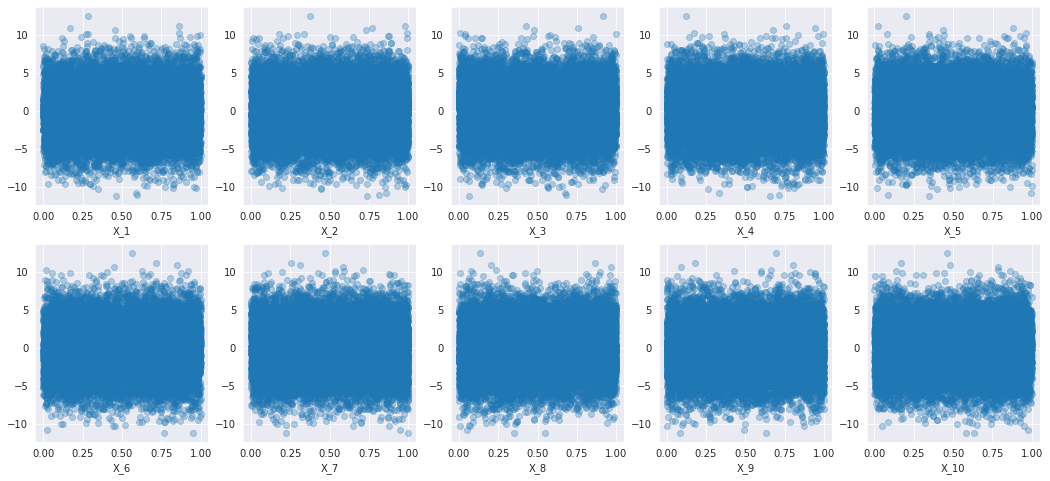

In [16]:
fig, ax = plt.subplots(2,5, figsize = (18,8))
i = 0
j = 0
for feature in data_part_1.iloc[:, 2:12].columns.tolist():
    ax[j,i].set_xlabel(feature)
    ax[j,i].scatter(data_part_1[feature], fitted.resid, alpha = 0.3)
    i+=1
    if i > 4:
        i = 0
        j +=1

Видим, что все остатки распределены линейно относительно фичей.  
Делаем вывод, что условие линейности отклика выполняется.

#### 2. Случайность выборки  
Данное условие выполняется при правильном дизайне эксперемента.  
Будем считать что для нашего набора данных данное условие выполнено.

#### 3. Полнота ранга.
Построим матрицу корреляций

In [17]:
data_part_1.iloc[:, 2:12].corr() 

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10
X_1,1.000000,-0.000354,0.001252,0.009507,-0.004616,0.011968,0.006329,0.002976,0.002121,0.004894
X_2,-0.000354,1.000000,-0.003164,-0.006788,0.008451,0.002302,0.006326,-0.001646,-0.008786,0.002035
X_3,0.001252,-0.003164,1.000000,-0.003472,-0.007262,-0.003872,0.004052,-0.006677,-0.000599,-0.009377
X_4,0.009507,-0.006788,-0.003472,1.000000,-0.010954,-0.001131,0.001923,-0.002946,0.005611,0.021488
X_5,-0.004616,0.008451,-0.007262,-0.010954,1.000000,-0.008475,-0.007144,-0.003614,0.008272,-0.003380
X_6,0.011968,0.002302,-0.003872,-0.001131,-0.008475,1.000000,0.000642,0.001326,0.006686,0.005137
X_7,0.006329,0.006326,0.004052,0.001923,-0.007144,0.000642,1.000000,-0.006870,0.006863,-0.003441
X_8,0.002976,-0.001646,-0.006677,-0.002946,-0.003614,0.001326,-0.006870,1.000000,0.000887,-0.004628
X_9,0.002121,-0.008786,-0.000599,0.005611,0.008272,0.006686,0.006863,0.000887,1.000000,-0.008186
X_10,0.004894,0.002035,-0.009377,0.021488,-0.003380,0.005137,-0.003441,-0.004628,-0.008186,1.000000


Видим, что ни у одной пары признаков корреляция не превашает 0.05. Также в регрессионной модели нет аномально больших коэффициентов.  
Считаем данное условие выполненым

#### 4. Нормальность ошибок.  
Построим распределение, Q-Q Plot и проверим данное предположение с помошью критерия Шапиро-Уилка

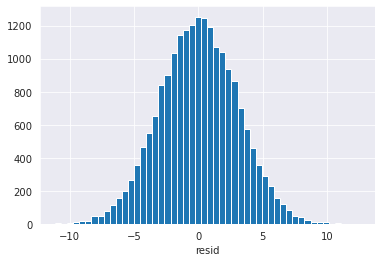

In [18]:
plt.xlabel('resid')
fitted.resid.hist(bins = 50)

Видим, что распределение очень похоже на нормальное.  
Построим Q-Q Plot

((array([-3.97862997, -3.7624649 , -3.64418052, ...,  3.64418052,
          3.7624649 ,  3.97862997]),
  array([-11.1485258 , -11.11323858, -10.76254135, ...,  10.95921614,
          11.20321716,  12.48987672])),
 (3.01158311146289, 2.3239521398484612e-15, 0.9999755081403386))

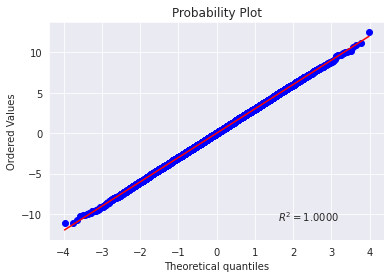

In [19]:
stats.probplot(fitted.resid, plot = plt, rvalue=True)

Видим, что точки лежат на прямой.  
Уже  можно сделать вывод о нормальности остатков.  
Проверим данное предположение формально с помощью теста Шапиро-Уилка

H0 - целевая переменная распределена нормально  
H1 - распределение отличается от нормального  
Примем уровень значимости $\alpha =$0.05

In [20]:
print('p_value = ', stats.shapiro(fitted.resid).pvalue)

p_value =  0.969084620475769


/home/dimsap/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Видим, что нулевую гипотезу отвергнуть нельзя, а зачит делаем вывод, что остатки распределены нормально 

#### 5. Гомоскедаксичность ошибок 
Проверим данное предположение с помощью теста Бройша — Пагана.  

H0 - дисперсия постоянна  
H1 - нулевая гипотеза не верна  
Примем уровень значимости  𝛼= 0.05

In [21]:
print('p_value =', sms.het_breuschpagan(fitted.resid, fitted.model.exog)[1])

p_value = 0.8045571431908418


Видим, что нулевая гипотеза принимается, а значит делаем вывод, что ошибки гомоскедаксичны и регрессия не нуждается в поправке(например Уайта)

#### 6. Случайность ошибок
То есть мат ожидание остатков должно быть равно нулю $E(\epsilon|x) = 0$  
Будем проверять данное предположение с помощью t-теста. Так как мы уже доказали нормальность остатков, можно смело его применять 

In [22]:
print('p_value =', stats.ttest_1samp(fitted.resid, 0).pvalue)

p_value = 0.9999999999999558


Делаем вывод что средние ошибок равно нулю

Таким образом, мы доказали состоятельность статистических оценок регрессии.  
Теперь мы можем доверять p_value полученные при проверки гипотезы о равенстве нулю коэффициентов, поэтому уберем признаки, p_value которых больше 0.05

In [23]:
model = smf.ols('y ~ W +X_1 + X_2  + X_4 + X_5 + X_6 ', data = data_part_1)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     51.70
Date:                Thu, 20 May 2021   Prob (F-statistic):           1.68e-63
Time:                        16:12:54   Log-Likelihood:                -50429.
No. Observations:               20000   AIC:                         1.009e+05
Df Residuals:                   19993   BIC:                         1.009e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3255      0.085     15.547      0.0

Таким образом, АТЕ оцененной с помощью регрессии, равен 
- $\tau = 0.5138$  
- доверительный интервал: [0.418       0.610]  

### 3) Propensity  Score

В качестве модели для определения вероятности принадлежности класса будем использовать LogReg

In [24]:
classif = LogisticRegression()
classif.fit(data_part_1.iloc[:, 2:12], data_part_1.W)
prob_W = classif.predict_proba(data_part_1.iloc[:, 2:12])


In [25]:
data_part_1['weight'] = [prob_W[i][0] if data_part_1.W[i] == 0 
                                      else prob_W[i][1] for i in range(data_part_1.shape[0])] # веса-вероятность

Построим взвешенную регрессию 

In [26]:
model = smf.wls('y ~ W +X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + X_9 + X_10', data = data_part_1,weights = 1/data_part_1.weight )
fitted = model.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            WLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     56.28
Date:                Thu, 20 May 2021   Prob (F-statistic):          1.09e-123
Time:                        16:12:55   Log-Likelihood:                -52544.
No. Observations:               20000   AIC:                         1.051e+05
Df Residuals:                   19988   BIC:                         1.052e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7000      0.121     14.067      0.0

Все условия, необходимые для корректных статистических оценок коэффициентов __выполнены__.
Проверка проводилась аналогично проверке выше. Выкладки опустим.  


Таким образом, при данном подходе получаем следующие оценки АТЕ: 

- $\tau = 0.5955$
- доверительный интервал [ 0.511       0.681]   

Доверительный интервал стал уже, однако сам ATE сместился 

##  Выводы часть 1

Для оценки АТЕ были применены следующие методы и получены следующие результаты:  
1. __Наивная оценка__:  
 $\tau = 0.4001$  
 доверительный интервал  [0.3161     0.4841]  
2. __Оценка с помощью регрессии__:  
 $\tau = 0.5138$  
 доверительный интервал: [0.418       0.610] 
3. __Propensity Score__:  
 $\tau = 0.5955$  
 доверительный интервал [ 0.511       0.681]   

Видим, что наивная оценка меньше чем оценка регрессии и Propensity Score. Скорее всего это связано с тем, что мы не могли учесть значения y_0 до начала эксперимента при наивной оценке.

Поскольку было показано, что treatment зависит от объектов, нет смысла доверять наивной оценке.  
За счет учёта ковариат, оценка регрессии внес корректировку в оценку АТЕ и данный результат является более убедительным.  
Качество Propensity Score во многом зависит от модели настройки весов, однака данная поправка нужна, так как данные поделены по группам не случайно. Также заметим, что доверительные интервалы ANCOVA и Propensity Score пересекаются.   

Наиболее убедительной является оценка Propensity Score, поскольку она учитывает не случайное разбиение по группам, а также учитывает ковариаты X

# Часть 2

In [27]:
data_part_2 = pd.read_csv('data/data/dataset_part2_students.csv', sep = '\t')
data_part_2['Y_i'] =  data_part_2.y_1 - data_part_2.y_0 

Скачаем данные и разобьем на treatment и control группы

In [28]:
control_part2 = data_part_2[data_part_2.W == 0.0].copy()
treatment_part2 = data_part_2[data_part_2.W == 1.0].copy()

Посмотим на данные 

In [29]:
data_part_2.head()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,Y_i
0,5.887156,2.785060,1.0,0.605978,0.733369,0.138947,0.312673,0.997243,0.128162,0.178993,0.752925,0.662161,0.784310,3.102097
1,2.232601,5.533515,0.0,0.096894,0.058571,0.962396,0.616557,0.086630,0.561272,0.616525,0.963843,0.574304,0.371161,-3.300914
2,0.144419,0.095546,1.0,0.452145,0.201850,0.569305,0.195096,0.583704,0.476313,0.517814,0.823099,0.732225,0.069056,0.048874
3,-2.446425,3.590472,1.0,0.672129,0.643485,0.828014,0.204469,0.617489,0.617701,0.301069,0.871741,0.589654,0.981770,-6.036897
4,2.163090,1.365405,0.0,0.442232,0.126318,0.508831,0.431786,0.915940,0.709016,0.890655,0.588886,0.636830,0.342209,0.797684


In [30]:
control_part2.describe()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,Y_i
count,4760.000000,4760.000000,4760.0,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000,4760.000000
mean,1.878542,0.816187,0.0,0.387120,0.400934,0.495181,0.502530,0.497533,0.499039,0.504281,0.503380,0.501267,0.498942,1.062355
std,2.071818,2.229064,0.0,0.290765,0.292887,0.289174,0.290800,0.289429,0.288836,0.287523,0.288944,0.284863,0.285771,3.032850
min,-4.979060,-6.972191,0.0,0.000103,0.000027,0.000052,0.000086,0.000049,0.000078,0.000092,0.000053,0.000300,0.000160,-9.793964
25%,0.492818,-0.700460,0.0,0.135603,0.144530,0.245455,0.250262,0.240251,0.245968,0.253266,0.258335,0.261758,0.256607,-1.038479
50%,1.912860,0.821256,0.0,0.317062,0.334214,0.492817,0.500135,0.497575,0.501865,0.502209,0.500092,0.495685,0.489355,1.112133
75%,3.307287,2.372783,0.0,0.603299,0.644434,0.744003,0.763300,0.748827,0.743682,0.751656,0.756322,0.748285,0.748729,3.136525
max,10.068061,9.988961,0.0,0.999685,0.999670,0.999702,0.999674,0.999935,0.999986,0.999875,0.999811,0.999841,0.999753,10.723960


In [31]:
treatment_part2.describe()

,y_1,y_0,W,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,Y_i
count,5240.000000,5240.000000,5240.0,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000,5240.000000
mean,2.309793,0.692534,1.0,0.592249,0.597398,0.501800,0.497781,0.501576,0.494910,0.501227,0.497676,0.503586,0.497798,1.617259
std,2.057201,2.347146,0.0,0.247503,0.247585,0.291216,0.288283,0.289987,0.288766,0.290932,0.290243,0.288506,0.289166,3.045323
min,-5.772625,-7.895281,1.0,0.002671,0.002005,0.000128,0.000978,0.000336,0.000002,0.000222,0.000177,0.000286,0.000036,-11.588370
25%,0.929238,-0.866791,1.0,0.409678,0.402247,0.251946,0.246770,0.251983,0.242064,0.252555,0.242903,0.251594,0.247341,-0.442215
50%,2.286631,0.679592,1.0,0.609595,0.618647,0.491949,0.497537,0.494650,0.495069,0.500515,0.496058,0.514799,0.496633,1.584368
75%,3.657720,2.298276,1.0,0.796363,0.804408,0.756589,0.746168,0.757603,0.743879,0.753963,0.750794,0.750788,0.750023,3.721860
max,10.488659,9.748107,1.0,0.999638,0.999707,0.999982,0.999913,0.999887,0.999989,0.999964,0.999944,0.999981,0.999915,13.164790


## 1) Проверка равенства средних в выборках после эксперемента и до его начала
Оценим точечно равенство средних

In [32]:
print('mean_diff_y1 =',treatment_part2.y_1.mean() - control_part2.y_1.mean())

mean_diff_y1 = 0.4312515969250956


In [33]:
print('mean_diff_y0 =', treatment_part2.y_0.mean() - control_part2.y_0.mean())

mean_diff_y0 = -0.12365317337202852


Видим, что точечные оценки не равны 0. 

Будем использовать t-test для проверки гипотезы о равенстве средних. Тогда, для корректных результатов такого теста, выборки должны быть из нормального распределения. Проверим это.

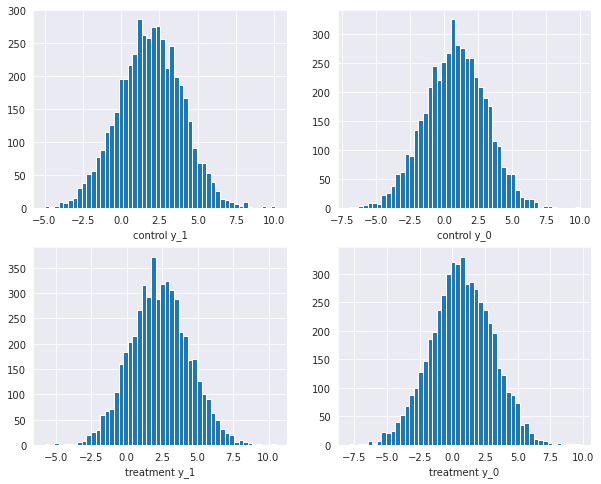

In [34]:
fig, ax = plt.subplots(2,2, figsize = (10,8))

ax[0][0].set_xlabel('control y_1')
ax[1][0].set_xlabel('treatment y_1')
ax[0][1].set_xlabel('control y_0')
ax[1][1].set_xlabel('treatment y_0')

control_part2.y_1.hist(bins = 50, ax = ax[0][0]);
treatment_part2.y_1.hist(bins = 50, ax = ax[1][0]);
control_part2.y_0.hist(bins = 50, ax = ax[0][1]);
treatment_part2.y_0.hist(bins = 50, ax = ax[1][1]);

Видим, что распределения похожи на нормальные

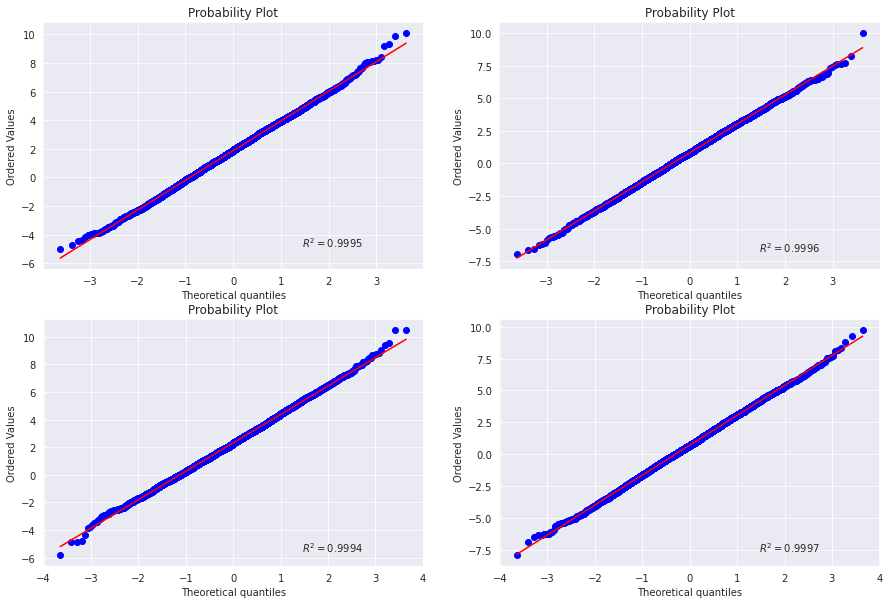

In [35]:
fig, ax = plt.subplots(2,2, figsize = (15,10))

stats.probplot(control_part2.y_1, plot = ax[0][0], rvalue=True);
stats.probplot(treatment_part2.y_1, plot = ax[1][0], rvalue=True);
stats.probplot(control_part2.y_0, plot = ax[0][1], rvalue=True);
stats.probplot(treatment_part2.y_0, plot = ax[1][1], rvalue=True);



Видим, что на всех графиках точки лежат на прямой, а $R^2$ близок к 1. Тогда, принимаем предположение о нормальности распределений и не будем проверять данную гипотезу с помощью теста Шапиро-Уилка(t-test допускает небольшие отклонения от нормальности).    
Тогда, используем t-test

In [36]:
print('для y после эксперимента (y_1) p-value = ',
      stats.ttest_ind(treatment_part2.y_1, control_part2.y_1, equal_var=False).pvalue)
print('для y до эксперимента (y_0) p-value = ', 
      stats.ttest_ind(treatment_part2.y_0, control_part2.y_0, equal_var=False).pvalue)
print('для Y = y_1 - y_0 p-value = ', 
      stats.ttest_ind(treatment_part2.y_1 - treatment_part2.y_0,
                      control_part2.y_1 - control_part2.y_0, equal_var=False).pvalue)

для y после эксперимента (y_1) p-value =  2.433950215267867e-25
для y до эксперимента (y_0) p-value =  0.0069160683710655525
для Y = y_1 - y_0 p-value =  8.987345710740511e-20


Видим, что во всех случаях гипотеза о равенстве средних отвергается на уровне значисомти 0.05

Посмотрим, как менялись значения y до и после эксперимента в обеих группах

Text(0, 0.5, 'y')

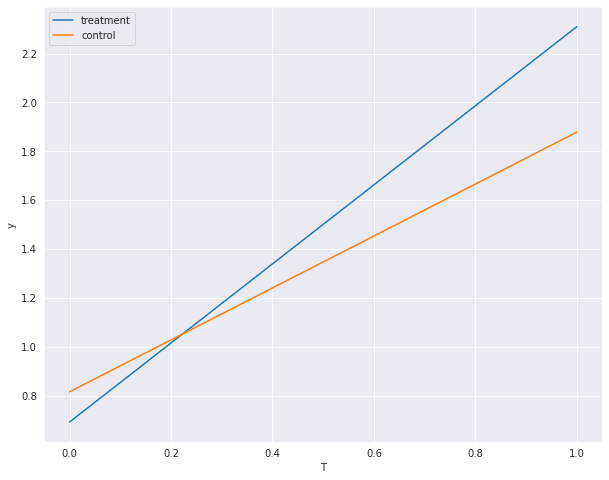

In [37]:
plt.figure(figsize=(10,8))
plt.plot([treatment_part2.y_0.mean(), treatment_part2.y_1.mean()]);
plt.plot([control_part2.y_0.mean(), control_part2.y_1.mean()]);
plt.legend(['treatment', 'control'])
plt.xlabel('T')
plt.ylabel('y')

In [38]:
print('разница между двумя группами до начала эксперимента',
      control_part2.y_0.mean() - treatment_part2.y_0.mean() )

разница между двумя группами до начала эксперимента 0.12365317337202852


Видим, что y_0 в двух группах существенно отличается

## 2) ATE воздействия 

 ### Randomate

Проверим качество рандомизации эксперента.  
Попробуем классифицироваь объекты на попадание в treatment и control группы на онове их признаков. Если получится добиться хоршего качества классификации, значит независимость treatment от объектов утверждать нельзя.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_part_2.iloc[:, 3:13], data_part_2.W, test_size = 0.2)
print('качество константного классификатора =' ,y_test[y_test == 1 ].shape[0]/y_test.shape[0])

качество константного классификатора = 0.514


In [40]:
classif = RandomForestClassifier(n_estimators=400)
classif.fit(X_train, y_train)
print('accuracy RF = ', classif.score(X_test, y_test))

accuracy RF =  0.7745


In [41]:
classif = LogisticRegression()
classif.fit(X_train, y_train)
print('accuracy LR = ', classif.score(X_test, y_test))

accuracy LR =  0.748


Видим, что как и в первой части, RF и LR из коробки без какой либо настройки параметров уже показывают неплохое качество классификации, а значит можно сделать вывод, что treatment зависит от объектов 

## 3) оценка ATE

### 1) Наивный подход

####  Оценим эффект после проведения эксперемента, не учитывая значения до: Y = y_1

In [42]:
tau_naive_part2 = (treatment_part2.y_1).mean() - (control_part2.y_1).mean()
print('tau_naive = ', tau_naive_part2)
CM = CompareMeans(DescrStatsW(treatment_part2.y_1), 
                  DescrStatsW(control_part2.y_1)).tconfint_diff()
print('доверительный интервал ',CM)

tau_naive =  0.4312515969250956
доверительный интервал  (0.35023437324600354, 0.5122688206041784)


####  Оценим эффект после проведения эксперемента, учитывая значения до: Y = y_1 - y_0

In [43]:
tau_naive_part2 = (treatment_part2.Y_i).mean() - (control_part2.Y_i).mean()
print('tau_naive = ', tau_naive_part2)
CM = CompareMeans(DescrStatsW(treatment_part2.Y_i), 
                  DescrStatsW(control_part2.Y_i)).tconfint_diff()
print('доверительный интервал ', CM)

tau_naive =  0.5549047702971162
доверительный интервал  (0.4356108511497596, 0.6741986894444794)


При оценке Y = y_1 - y_0, ATE получается больше на разницу между y_0 до начала эксперимента, т.е. на 0.12

Как было показано выше, полной независимости treatment от объектов нет, поэтому не стоит доверть данным оценкам 

### 2) Регрессия 
Перед оценкой ATE сделаем следующие предположения о выборках:  
- 1) __unconfoundedness__ :   
treatment assignment не зависит от результата эксперемента при условии контроля за X. Как было показано выше, полная независимость не выполняется, однако это не мешает выполнению данного предположения.
- 2) __Overlap__ :  
Нет таких характерных объектов, для которых не возможен treatment.


будем строить регрессию вида $ Y_{i} = \alpha + \beta X_{i} + \tau W_{i} + \epsilon$, где $Y_{i} = y_1 - y_0$

In [44]:
model = smf.ols('Y_i ~ W + X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + X_9 + X_10', data = data_part_2)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    Y_i   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     8.879
Date:                Thu, 20 May 2021   Prob (F-statistic):           6.27e-16
Time:                        16:13:06   Log-Likelihood:                -25298.
No. Observations:               10000   AIC:                         5.062e+04
Df Residuals:                    9988   BIC:                         5.071e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7242      0.170      4.266      0.0

Все условия, необходимые для корректных статистических оценок коэффициентов __выполнены__.  
Проверка проводилась аналогично части первой. Выкладки опустим. 

Видим, что если учитывать начальные значения y_0 и настраивать регрессию на Y = y_1 - y_0 почти все признаки не играют существенной роли. Обратная ситация будет если настраивать регрессию на Y = y_1, тогда y_0 учтется за счет признаков обьектов. Далее это будет рассмотрено в пункте __ANCOWA__.  

Уберем все незначащие признаки 

In [45]:
model = smf.ols('Y_i ~ W +  X_3 ', data = data_part_2)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    Y_i   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     45.54
Date:                Thu, 20 May 2021   Prob (F-statistic):           2.06e-20
Time:                        16:13:06   Log-Likelihood:                -25301.
No. Observations:               10000   AIC:                         5.061e+04
Df Residuals:                    9997   BIC:                         5.063e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9169      0.068     13.479      0.0

Таким образом, при данном подходе получаем следующие оценки АТЕ: 

- $\tau = 0.5530$
- доверительный интервал [0.434       0.672]   

Видим, что доверительный интервал стал немного более узким относительно наивного подхода

### 3) ANCOWA

 Будем строить регрессию вида $y_{i1} = \alpha + \beta y_{i0} + \tau W + \epsilon _{i}$ , где $\tau$ - оценка ATE

#### 3.1) подставим $y_{i0}$ в явном виде 

In [46]:
model = smf.ols('y_1 ~ W + y_0', data = data_part_2)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_1   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     58.70
Date:                Thu, 20 May 2021   Prob (F-statistic):           4.54e-26
Time:                        16:13:06   Log-Likelihood:                -21431.
No. Observations:               10000   AIC:                         4.287e+04
Df Residuals:                    9997   BIC:                         4.289e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8572      0.031     60.304      0.0

Все условия, необходимые для корректной статистической оценки коэффициентов регрессии __были проверены__ аналогично части 1. Выкладки также опустим 

Видим, что получили чуть скорректированную оценку для Y = y_1. доверительные интервалы более узкими не стали.  Таким образом, при данном подходе получаем следующие оценки АТЕ: 

- $\tau = 0.4345$
- доверительный интервал [0.353       0.516]   

#### 3.2) вместо  $y_{i0}$ будем использовать признаки Х объектов  
Фактически данный подход идентичен обычной регрессии, только в качестве таргета учитывается не  $Y = y_{1} - y_{0}$, a $Y = y_{1}$, а поправка от y_0 добавляется за счет признаков X

In [47]:
model = smf.ols('y_1 ~ W + X_1 + X_2 + X_3 + X_4 + X_5 + X_6 + X_7 + X_8 + X_9 + X_10', data = data_part_2)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_1   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     39.48
Date:                Thu, 20 May 2021   Prob (F-statistic):           2.63e-84
Time:                        16:13:06   Log-Likelihood:                -21277.
No. Observations:               10000   AIC:                         4.258e+04
Df Residuals:                    9988   BIC:                         4.266e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1967      0.114     10.538      0.0

Все условия, необходимые для корректной статистической оценки коэффициентов регрессии __были проверены__ аналогично части 1. Выкладки также опустим.

Уберем статистически незначимые признаки 

In [48]:
model = smf.ols('y_1 ~ W + X_1 + X_2 + X_4 + X_5 + X_7', data = data_part_2)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_1   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     70.95
Date:                Thu, 20 May 2021   Prob (F-statistic):           6.20e-87
Time:                        16:13:06   Log-Likelihood:                -21281.
No. Observations:               10000   AIC:                         4.258e+04
Df Residuals:                    9993   BIC:                         4.263e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1874      0.081     14.622      0.0

Таким образом, получаем скорректированную оценку для $Y = y_{1} - y_{0}.$ доверительные интервалы стали более узкими.  Получаем следующие оценки АТЕ: 

- $\tau = 0.5455$
- доверительный интервал [0.454       0.637]   

#### 3.3) Используем модифицкацию 

Обучим регрессию и получим остатки 

In [49]:
model = smf.ols('y_1 ~ W ', data = data_part_2)
fitted = model.fit()
data_part_2['m'] = fitted.resid

control_part2 = data_part_2[data_part_2.W == 0.0].copy()
treatment_part2 = data_part_2[data_part_2.W == 1.0].copy()

Обучим модели для treatment и control и получим оценки остатков. В качестве алогритма возьмем линейную регрессию.

In [50]:
classif = LinearRegression()

classif.fit(pd.concat([control_part2.iloc[:, 3:13],control_part2.y_0], axis = 1), control_part2.m)
a_control = classif.predict(pd.concat([data_part_2.iloc[:, 3:13],data_part_2.y_0], axis = 1))

classif.fit(pd.concat([treatment_part2.iloc[:, 3:13],treatment_part2.y_0], axis = 1), treatment_part2.m)
a_treatment = classif.predict(pd.concat([data_part_2.iloc[:, 3:13],data_part_2.y_0], axis = 1))

data_part_2['a_treatment'] = a_treatment
data_part_2['a_control'] = a_control

P_control = control_part2.shape[0]/data_part_2.shape[0]
P_treatment = 1 - P_control

Внесем поправку для y_1 и построим регрессию для оценки ATE

In [51]:
data_part_2['ancowa_mod'] = data_part_2.y_1 - ((1 - P_treatment)*data_part_2.a_treatment +
                                               (0 - P_control)*data_part_2.a_control)
model = smf.ols('ancowa_mod ~ W', data = data_part_2)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:             ancowa_mod   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     102.2
Date:                Thu, 20 May 2021   Prob (F-statistic):           6.41e-24
Time:                        16:13:07   Log-Likelihood:                -21445.
No. Observations:               10000   AIC:                         4.289e+04
Df Residuals:                    9998   BIC:                         4.291e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8303      0.030     61.120      0.0

Все условия, необходимые для корректной статистической оценки коэффициентов регрессии __были проверены__ аналогично части 1. Выкладки также опустим.  

Таким образом, получаем скорректированную оценку для $Y = y_{1}.$ доверительные интервалы остались такими же как и при обычном использование ANCOWA.  Получаем следующие оценки АТЕ: 

- $\tau = 0.4183 $
- доверительный интервал [0.337       0.499]   

## 4) Difference in difference

Будем строить регрессию следующего вида:  
$y_{iT} = \alpha + \beta T_{i} + \gamma W_{i} + \tau I_{i} * W_{i}$

Создадим новый DF, разделив каждый обьект на два с y = y_0 и с y = y_1, а также добавим индикатор Т и построим регрессию 

In [52]:
DID_1 = data_part_2[['y_1', 'W']].copy()
DID_1.columns = ['y', 'W']
DID_1['T'] = 1

DID_0 = data_part_2[['y_0', 'W']].copy()
DID_0.columns = ['y', 'W']
DID_0['T'] = 0

DID = pd.concat([DID_1, DID_0])

In [53]:
model = smf.ols('y ~ T + W + T*W', data = DID)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     676.8
Date:                Thu, 20 May 2021   Prob (F-statistic):               0.00
Time:                        16:13:07   Log-Likelihood:                -43972.
No. Observations:               20000   AIC:                         8.795e+04
Df Residuals:                   19996   BIC:                         8.798e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8162      0.032     25.820      0.0

Все условия, необходимые для корректной статистической оценки коэффициентов регрессии были проверены аналогично части 1. Выкладки также опустим.

Получили скорректированную оценку для $Y = y_{1} - y_{0}.$. Доверительный интервал по сравнению с наивным подходом стали немного более широким.  Получаем следующие оценки АТЕ: 

- $\tau =  0.5549 $
- доверительный интервал [0.434       0.676]   

### 5) Cuped

Попробуем уменьшить дисперсию Y = y_1, сделав поправку следующего вида:  
$cuped = y_{1} - (y_{0} - \overline{y_{0}}) \theta $  
где $\theta = \frac{cov(y_{1},y_{0})}{var(y_{0})} $

In [54]:
tetta = np.cov(data_part_2.y_0, data_part_2.y_1)[0][1] / np.var(data_part_2.y_0)
data_part_2['cuped'] =  data_part_2.y_1 - (data_part_2.y_0 - data_part_2.y_0.mean())*tetta

Посмотрим, уменьшиласть ли дисперсия после введения данной поправки

variance y_1 =  4.306770426144426
variance cuped = 4.3038410435152405


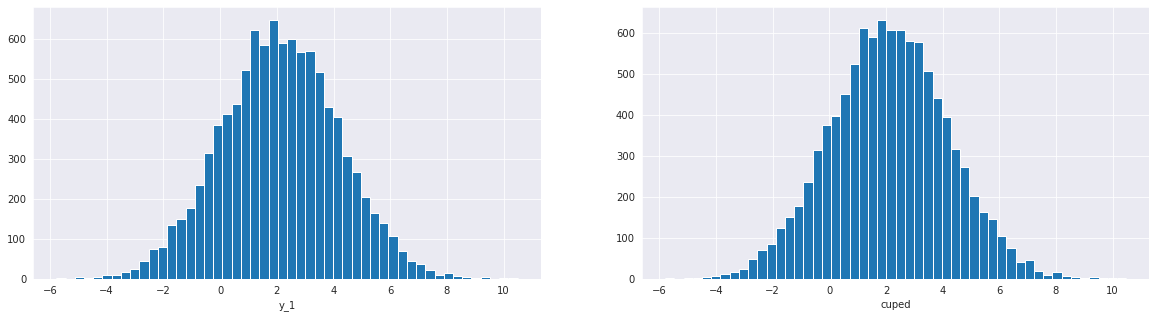

In [55]:
print('variance y_1 = ',data_part_2.y_1.var())
print('variance cuped =', data_part_2.cuped.var())

fig, ax = plt.subplots(1,2, figsize = (20,5))

ax[0].set_xlabel('y_1')
ax[1].set_xlabel('cuped')

data_part_2.y_1.hist(bins = 50, ax = ax[0]);
data_part_2.cuped.hist(bins = 50, ax = ax[1]);

Видим, что дисперсия почти не поменялась  
Оценим ATE с помощью регрессии настроенной только на W (результаты полученные таким методом аналогичны провденеию t-теста)

In [56]:
data_part_2['Y_cuped'] = data_part_2.cuped - data_part_2.y_0

In [57]:
model = smf.ols('cuped ~ W', data = data_part_2)
print(fitted.summary())                                             
fitted = model.fit() 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     676.8
Date:                Thu, 20 May 2021   Prob (F-statistic):               0.00
Time:                        16:13:08   Log-Likelihood:                -43972.
No. Observations:               20000   AIC:                         8.795e+04
Df Residuals:                   19996   BIC:                         8.798e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8162      0.032     25.820      0.0

Все условия, необходимые для корректной статистической оценки коэффициентов регрессии были проверены аналогично части 1. Выкладки также опустим.  

Получили оценку для $Y = y_{1}.$. Доверительные интервалы по сравнению с наивным подходом почти не изменились.  Получаем следующие оценки АТЕ: 

- $\tau =   0.4342 $
- доверительный интервал [0.353       0.515]   

### 6) Propensity  Score

Найдем вероятность принадлежности обьекта к treatment $e$ и сопоставим с каждым объектом если он в control $(1-e)$, а если в treatment $e$

In [58]:
classif = LogisticRegression()
classif.fit(data_part_2.iloc[:, 3:13], data_part_2.W)
prob_W = classif.predict_proba(data_part_2.iloc[:, 3:13])
data_part_2['weight'] = [prob_W[i][0] if data_part_2.W[i] == 0 
                                      else prob_W[i][1] for i in range(data_part_2.shape[0])]

Для оценки ATE построим взвешенную регрессию

In [59]:
model = smf.wls('Y_i ~ W', data = data_part_2, weights = 1/data_part_2.weight )
fitted = model.fit()
print(fitted.summary())

                            WLS Regression Results                            
Dep. Variable:                    Y_i   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     68.92
Date:                Thu, 20 May 2021   Prob (F-statistic):           1.16e-16
Time:                        16:13:08   Log-Likelihood:                -26380.
No. Observations:               10000   AIC:                         5.276e+04
Df Residuals:                    9998   BIC:                         5.278e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0178      0.041     24.549      0.0

Все условия, необходимые для корректной статистической оценки коэффициентов регрессии были проверены аналогично части 1. Выкладки также опустим.

Получили скорректированную оценку для $Y = y_{1} - y_{0}.$. Доверительные интервалы по сравнению с наивным подходом почти не изменились.  Получаем следующие оценки АТЕ: 

- $\tau =   0.5102 $
- доверительный интервал [0.390       0.631]  

## 4)  Выводы по части 2

Для оценки АТЕ были применены следующие методы и получены следующие результаты:  

1. __Наивная оценка__:  
   - __1.1. $Y = y_{1}$__    
        - $\tau = 0.4001$  
        - доверительный интервал  [0.3161     0.4841]   
   - __1.2. $Y = y_{1} - y_{0}$__    
        - $\tau = 0.5549$  
        - доверительный интервал  [0.4356     0.6742]
        
        
2. __Регрессия__:   

 $\tau = 0.5530$  
 доверительный интервал: [0.434    0.672] 
 
 
3. __ANCOWA__:  

   - __3.1. $y_{i0}$ в явном виде__   
        - $\tau = 0.4345 $  
        - доверительный интервал  [0.353      0.516]   
   - __3.2. вместо  $y_{i0}$ будем использовать признаки Х объектов__   
        - $\tau = 0.5455$  
        - доверительный интервал  [0.454 0.637]
   - __3.3. При использование модификации (настраиваемся на остатки)__
        - $\tau = 0.4183$  
        - доверительный интервал  [0.337 0.499]
         
         
4. __Difference in difference__:  

 $\tau = 0.5549$  
 доверительный интервал: [0.434 0.676]  
 
 
5. __Cuped__:   

 $\tau = 0.4342$  
 доверительный интервал: [0.353 0.515]   
  
  
6. __Propensity Score__:  

 $\tau = 0.5102 $  
 доверительный интервал: [0.390 0.631] 
 


Поскольку мы видим, что между целевыми показателями control и treatment группой до начала эксперимента есть существенное отличие, нет смысла доверять методам, которые не учитывают эту разницу. Также несостоятельна наивная оценка в силу отсутствия полностью случайного разбиения по группам.     

Таким образом, помимо наивной оценки, нас также не интерисуют результаты, полученные с помощью ANCOWA при подстановки $y_{i0}$ в явном виде, при использование модификации  и Cuped. Также стоит отметить, что в данной задаче применение Cuped не оправдано также тем, что после внесения поправки дисперсия $y$ почти не поменялась.   

Рассмотрим подробнее результаты полученные с помощью регрессии, ANCOWA с использованием признаков, Difference in difference и Propensity Score. Видим, что результат Difference in difference почти не отличается от наивного подхода, онако мы получаем даже более широкий доверительный интервал, а значит не будем рассматривать результаты, полученные данным методом. Сравнивая результаты регрессии и ANCOWA с использованием признаков видим, что доверительные интервала полученные c помощью ANCOWA значительно более узкие, а значит отдаем предпочтение данному методу.

Осталось сравнить ANCOWA с использованием признаков и Propensity Score. Оценка, полученная для Propensity Score во многом зависит от качества модели, которая находит веса признаков. В данной задаче нас интересует данный подход, поскольку было показано, что treatment зависит от объектов. Однако видим, что доверительный интервал, полученный с помощью ANCOWA почти полностью вложен в доверительый интервал от Propensity Score, который гораздо шире, а  значит использование поправки на принадлежность обекта к tretment не дает нам значимого улучшения оценки, а лишь увеличивает диапазон возможного ATE.  

Таким образом, подводя итог вышесказанному, делаем вывод о том, что __лучшим__ способом нахождения ATE в данной задаче является __ANCOWA, где вместо  $y_{i0}$ используются признаки Х объектов__

# Часть 3

Скачаем данные и разобьем на treatment и control группы

In [60]:
data_part_3 = pd.read_csv('data/data/dataset_part3_students.csv', sep = '\t')
control_part3 = data_part_3[data_part_3.treatment == 'control']
treatment_part3 = data_part_3[data_part_3.treatment == 'treatment']

Посмтрим на данные

In [61]:
data_part_3.head()

,treatment,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,...,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
0,control,0.034351,0.550725,-1.348524,-0.029591,0.499535,-0.412464,0.933588,-0.522954,-0.029591,...,-0.314573,-0.879456,0.640264,1.165722,0.570495,0.529443,0.227962,1.929914,0.798664,0
1,control,-1.059404,0.299404,0.220273,-1.569660,1.084204,-2.167118,1.216469,-0.744547,-1.569660,...,0.303664,1.080643,2.646483,-0.329690,1.725636,1.434649,-2.064893,0.188000,-1.134651,0
2,control,0.051934,2.338729,-0.341017,-1.099362,0.693090,-2.424267,1.572066,-0.212798,-1.099362,...,-0.083721,-1.981712,0.224777,2.038004,2.516398,2.324280,-3.182196,-0.888490,-1.402561,0
3,treatment,0.667770,0.539316,0.468719,-0.840885,-0.708331,0.126634,1.275854,-0.954919,-0.840885,...,-0.752011,-0.347319,-1.659402,-0.871980,-0.893513,-0.658078,-2.704997,-0.390745,-1.578004,1
4,control,-1.416158,2.486628,0.496402,-1.174618,2.738267,-4.756755,-0.180918,-1.281432,-1.174618,...,-1.198151,-0.232961,0.948875,1.210523,1.536723,1.548610,-0.926435,0.972459,-0.711251,0


In [62]:
control_part3.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.366829,1.002973,0.002849,-0.752908,1.000805,-1.667376,0.998831,-0.003893,-0.752908,0.003377,...,0.005911,-0.000004,0.726265,0.725486,0.725914,0.710574,-0.454185,0.451871,-0.226383,0.123400
std,0.746487,1.258198,1.002803,1.374147,1.245173,2.062123,1.039991,0.998991,1.374147,1.000768,...,0.997605,1.000011,1.298523,1.158037,1.374577,1.124633,1.454493,1.346033,0.883030,0.328897
min,-4.260103,-4.311804,-4.343408,-5.543052,-5.983915,-9.670401,-4.157957,-4.227920,-5.543052,-4.777980,...,-4.294128,-4.401616,-4.612110,-5.638730,-4.394009,-3.506754,-6.811223,-4.128365,-4.069459,0.000000
25%,-0.862295,0.155406,-0.671460,-1.660871,0.169458,-3.068365,0.313636,-0.676526,-1.660871,-0.671950,...,-0.666181,-0.675966,-0.106732,0.101311,-0.227216,-0.066023,-1.525151,-0.549392,-0.840779,0.000000
50%,-0.374992,1.002943,0.005735,-0.858696,1.003375,-1.690208,0.997153,-0.006442,-0.858696,0.008952,...,0.003600,0.002050,0.796608,0.839811,0.764678,0.739908,-0.369874,0.505542,-0.190663,0.000000
75%,0.120553,1.850634,0.678578,-0.005413,1.830796,-0.296957,1.678991,0.667326,-0.005413,0.676970,...,0.679084,0.673407,1.617153,1.502065,1.681685,1.489296,0.744728,1.432666,0.411224,0.000000
max,3.696048,6.218324,4.976332,7.459716,6.375762,9.094394,6.886500,5.439752,7.459716,4.325225,...,4.482854,4.322746,5.634097,4.982925,6.185047,5.036154,4.464374,5.539067,2.959013,1.000000


In [63]:
treatment_part3.describe()

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_14,X_15,X_16,X_17,X_18,X_19,X_20,X_21,X_22,conversion
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-0.366933,0.999009,0.001021,-0.760172,0.999362,-1.666837,1.002578,0.002472,-0.760172,0.006918,...,-0.004523,-0.002329,0.735338,0.724299,0.732731,0.715613,-0.455246,0.456396,-0.225979,0.182470
std,0.747614,1.263536,1.005301,1.375648,1.244454,2.064412,1.041281,1.000017,1.375648,1.002960,...,0.996372,0.999556,1.292815,1.155659,1.377788,1.127341,1.455326,1.341706,0.882412,0.386233
min,-4.204262,-4.369495,-4.670829,-5.754862,-4.638167,-10.220168,-4.166615,-4.215775,-5.754862,-4.630134,...,-4.528661,-4.026676,-5.578769,-5.449656,-4.638177,-3.808153,-6.462974,-4.291047,-3.891525,0.000000
25%,-0.863747,0.143495,-0.673526,-1.663068,0.166422,-3.052893,0.317361,-0.673382,-1.663068,-0.672640,...,-0.672427,-0.680700,-0.088521,0.107716,-0.229995,-0.069123,-1.525303,-0.545567,-0.833260,0.000000
50%,-0.371219,0.995926,0.004240,-0.870496,1.000029,-1.683343,1.003159,0.003135,-0.870496,0.006637,...,-0.008813,-0.002654,0.803795,0.839300,0.764249,0.741015,-0.375824,0.506757,-0.195989,0.000000
75%,0.120371,1.851978,0.681745,-0.019459,1.834009,-0.296739,1.684772,0.676232,-0.019459,0.681211,...,0.664021,0.667918,1.624713,1.498651,1.691478,1.500556,0.749593,1.431494,0.411306,0.000000
max,4.121888,6.726024,4.682374,9.593777,6.820825,7.754636,7.081333,4.296814,9.593777,4.248228,...,4.342713,5.125249,5.660769,4.656119,6.418469,5.431105,5.147421,6.085848,3.196679,1.000000


## 1) Оценим АТЕ воздействия

Для начала проверим гипотезу о равенстве долей конверсии в двух группах.  
Посмотрим на доверительные интервалы для каждой из долей. Воспользуемся методом Уилсона.

In [64]:
print('доверительный интервал для доли конверсии в treatment группе ', 
      proportion_confint(treatment_part3.conversion.sum(), treatment_part3.shape[0], method='wilson'))

доверительный интервал для доли конверсии в treatment группе  (0.1800883691502143, 0.1848760254810627)


In [65]:
print('доверительный интервал для доли конверсии в control группе ',
      proportion_confint(control_part3.conversion.sum(), control_part3.shape[0], method='wilson'))

доверительный интервал для доли конверсии в control группе  (0.12137597443752296, 0.1254529583188746)


Видим, что доверительные интервалы не пересекаются.   
Посмотрим, пересекает ли ноль доверительный интервал для разности долей двух выборок.

In [66]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [67]:
confint_proport = proportions_diff_confint_ind(treatment_part3.conversion, control_part3.conversion)
print('доверительный интервал для разности долей ', confint_proport)

доверительный интервал для разности долей  (0.05592581737573007, 0.06221418262426993)


Видим, что ноль также не пересекается. В таком случае можно предположить наличие статистически значимой разнице между двумя долями.  
Проверим это с помощью Z-критерий для разности долей в независимых выборках.

Функция для нахождения Z статистики 

In [68]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

Функция для проведения z-теста:  
H0 - доли в двух выборках равны  
H1 - дол в двух выборках не равны (двухсторонняя альтернатива)

In [69]:
def proportions_diff_z_test(z_stat):
    return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

z_stat = proportions_diff_z_stat_ind(treatment_part3.conversion, control_part3.conversion)
print('p_value = ',proportions_diff_z_test(z_stat))

p_value =  0.0


Видим, что нулевая гипотеза уверенно отвергается на уровне значимсоти 0.05

Проверим, зависит ли treatment от объектов 

In [70]:
LE = LabelEncoder()
LE.fit(data_part_3.treatment)
y = LE.transform(data_part_3.treatment)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(data_part_3.iloc[:, 1:23], y, test_size = 0.3)
print('качество константного классификатора = ', y_test[y_test == 1 ].shape[0]/y_test.shape[0])

качество константного классификатора =  0.50105


In [72]:
classif = LogisticRegression()
classif.fit(X_train, y_train)
print('accuracy LR = ', classif.score(X_test, y_test))

accuracy LR =  0.4998666666666667


In [73]:
classif = RandomForestClassifier(n_estimators=400)
classif.fit(X_train, y_train)
print('accuracy RF = ', classif.score(X_test, y_test))

accuracy RF =  0.49975


Видим, что качество модели не лучше чем качество константного классификатора, а значит можно сделать вывод что treatment не зависит от объектов 

Так как экспримент был хорошо рандомизирован будем использовать наивный подход для оценки ATE, поскольку в данном случае его оценкам можно доверять с большей уверенностью.  
Доверительный интервал при таком подходе был найден ранее.

In [74]:
tau_naive_part3 = treatment_part3.conversion.mean() - control_part3.conversion.mean()
print('tau_naive = ', tau_naive_part3)
print('доверительный интервал ', confint_proport)

tau_naive =  0.05907
доверительный интервал  (0.05592581737573007, 0.06221418262426993)


## 2)Оценим Cate для каждого объекта

Перед оценкой СATE сделаем следующие предположения о выборках:  
- 1) __unconfoundedness__ :   
treatment assignment не зависит от результата эксперемента при условии контроля за X. Как было показано выше, полная независимость не выполняется, однако это не мешает выполнению данного предположения.
- 2) __Overlap__ :  
Нет таких характерных объектов, для которых не возможен treatment.

В качестве метода определения САТЕ будем использовать __T-learner__  
Обучим модель $\mu_{0}$ на control группе, модель $\mu_{1}$ на treatment группе.  
Будем определять САТЕ для каждого объекта как: $ \tau_{cate}(x) = \mu_{1}(x) - \mu_{0}(x)$  
В качестве алгоритма обучения возьмем случайный лес

In [75]:
mu_1 = RandomForestRegressor(n_estimators=50)
mu_1.fit(treatment_part3.iloc[:, 1:23], treatment_part3.conversion)
mu_1_predict = mu_1.predict(data_part_3.iloc[:, 1:23])

mu_0 = RandomForestRegressor(n_estimators=50)
mu_0.fit(control_part3.iloc[:, 1:23], control_part3.conversion)
mu_0_predict = mu_0.predict(data_part_3.iloc[:, 1:23])

tau = mu_1_predict - mu_0_predict

data_part_3['tau_Tlearner'] = tau

## 3) Проставим рекомендации к воздействию на каждый объект и найдем конверсию при оптимальном воздействии.
Будем рекомендовать воздействовать на клиента если $\tau_{cate}$ > 0 

In [76]:
data_part_3['W_optimal'] = [1 if x > 0 else 0 for x in data_part_3.tau_Tlearner ]

Посмотрим, на скольких человек рекомендуется воздействовать

In [77]:
data_part_3.W_optimal.sum()

73813

Т.е. вместо 100 000 человек воздействие было оказано на 73553

Посчитаем ожидаемую ковесрию как долю пользователей с conversion = 1  среди тех на которых было оказано оптимальное воздействие.  

In [78]:
print('ожидаемая конверсия составляет ' ,
      np.round(data_part_3[data_part_3.W_optimal ==  1].conversion.mean() * 100, 2), '%')

ожидаемая конверсия составляет  20.45 %


Конверсия при изначальном воздействие составляла 18 %

## Выводы часть 3

Таким образом, в ходе выполнения данного задания был реализован метод T-learner для оценки САТЕ для каждого объекта. На основание полученных оценок условного эффекта воздействия для каждого объекта было проставлено рекомендуемое воздействие.  

Оценка конверсии при рекомендованном воздействие показала, что мы можем воздейстовать на меньшее кол-во объектов, и при это получить большую конверсию.